<a href="https://colab.research.google.com/github/edponce/DoyleInvestigators/blob/develop/Project1_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###$\color{brown}{\rm Imports}$

In [1]:
import os
import re
import copy
import pprint
import itertools
import collections
import urllib.request
import urllib.parse
import numpy as np
import seaborn as sns  # 0.10.1 (0.11 fails in barplot)
import pandas
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###$\color{brown}{\rm Corpus~Selection}$

In [3]:
CORPUS_URL = {
    'The Valley of Fear': "http://www.gutenberg.org/files/3289/3289.txt",
    'A Study in Scarlet': "http://www.gutenberg.org/files/244/244.txt",
    'The Sign of the Four': "http://www.gutenberg.org/files/2097/2097.txt",
    'The Hound of the Baskervilles': "http://www.gutenberg.org/files/2852/2852.txt",
    'The Boscombe Valley Mystery': 'https://www.gutenberg.org/files/1661/1661.txt',
}

###$\color{brown}{\rm Characters~and~Aliases}$

In [4]:
# Names and aliases are case-sensitive
CHARACTERS_NAMES = {
    'The Valley of Fear': {
        'main': [
            ['Sherlock Holmes'],
            ['Watson'],
            ['John Douglas', 'Birdy Edwards', 'Mr._Douglas', 'Steve Wilson', 'Jack McMurdo'],
            ['McGinty', 'Boss', 'Bodymaster'],
            ['Alec MacDonald', 'inspector', 'Inspector', 'Mr._Mac', 'Mac'],
            ['White Mason', 'police_officer'],
            ['Mrs._Douglas'],
            ['Cecil James Barker'],
            ['Ettie Shafter'],
            ['Fred Porlock'],
            ['Professor_Moriarty', 'professor'],
            ['Sergeant Wilson'],
            ['Ted Baldwin'],
            ['Captain Marvin'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['Watson'],
            ['Alec MacDonald', 'inspector', 'Inspector', 'Mr._Mac', 'Mac'],
            ['White Mason', 'police_officer'],
        ],
        'perpetrators': [
            ['Professor Moriarty', 'professor'],
            ['Ted Baldwin'],
        ],
        'suspects': [
            ['Mrs. Douglas'],
            ['Cecil James Barker'],
        ],
    },
    'A Study in Scarlet': {
        'main': [
            ['Sherlock Holmes'],
            ['Watson'],
            ['John', 'John_Ferrier'],  # do not clash with Lucy Ferrier
            ['Lucy'],
            ['Enoch Drebber'],
            ['Joseph Stangerson'],
            ['Lestrade'],
            ['Gregson'],
            ['Jefferson Hope', 'cabman'],
            ['Brigham Young'],
            ['Madame_Charpentier', 'Madame', 'Mrs._Charpentier'],
            ['Arthur_Charpentier', 'Arthur'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['Watson'],
            ['Gregson'],
            ['Lestrade'],
        ],
        'perpetrators': [
            ['Jefferson Hope', 'cabman'],  # Part 1
            # ['Enoch Drebber'],  # Part 2
            # ['Joseph Stangerson'],  # Part 2
        ],
        'suspects': [
            ['Enoch Drebber'],  # Part 1
            ['Joseph Stangerson'],  # Part 1
            ['Madame_Charpentier', 'Madame', 'Mrs._Charpentier'],  # Part 1
            ['Arthur_Charpentier', 'Arthur'],  # Part 1
        ],
    },
    'The Sign of the Four': {
        'main': [
            ['Sherlock Holmes'],
            ['Watson'],
            ['Mary_Morstan', 'Miss_Morstan'],
            ['Arthur_Morstan', 'Captain_Morstan'],
            ['Major_Sholto', 'Major', 'major'],
            ['Thaddeus_Sholto', 'Thaddeus'],
            ['Bartholomew_Sholto', 'Bartholomew'],
            ['Jonathan Small'],
            ['Tonga'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['Watson'],
        ],
        'perpetrators': [
            ['Jonathan Small'],
            ['Tonga'],
        ],
        'suspects': [
            ['Major_Sholto', 'Major', 'major'],
            ['Thaddeus_Sholto', 'Thaddeus'],
        ],
    },
    'The Hound of the Baskervilles': {
        'main': [
            ['Sherlock Holmes'],
            ['Watson'],
            ['James Mortimer', 'doctor', 'Doctor'],
            ['Charles_Baskerville', 'Sir_Charles'],
            ['Henry Baskerville', 'Sir_Henry'],
            ['Jack', 'Stapleton'],
            ['Miss_Stapleton', 'Beryl'],
            ['Barrymore', 'butler'],
            ['Selden'],
            ['Laura Lyons'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['Watson'],
            ['Lestrade'],
        ],
        'perpetrators': [
            ['Jack', 'Stapleton'],
        ],
        'suspects': [
            ['Barrymore', 'butler'],
            ['Laura Lyons'],
        ],
    },
    'The Boscombe Valley Mystery': {
        'main': [
            ['Sherlock Holmes'],
            ['Watson'],
            ['Lestrade'],
            ['James McCarthy'],
            ['John_Turner', 'Mr._Turner', 'Turner'],
            ['Alice', 'Miss_Turner'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['Watson'],
            ['Lestrade'],
        ],
        'perpetrators': [
            ['John_Turner', 'Mr._Turner', 'Turner'],
        ],
        'suspects': [
            ['James McCarthy'],
        ],
    },
}

###$\color{brown}{\rm Load~Corpus}$
Read a corpus from web page or file to start processing.

In [5]:
def get_corpus_from_url(url):
    with urllib.request.urlopen(url) as fd:
        text = fd.read()
        try:
            return text.decode('utf-8')
        except UnicodeDecodeError:
            return text.decode('iso-8859-1')


def get_corpus_from_file(file):
    with open(file) as fd:
        return fd.read()


def get_corpus(key):
    def validate_url(url):
        parsed_url = urllib.parse.urlparse(url)
        return all([parsed_url.scheme, parsed_url.netloc, parsed_url.path])

    # Check if a filename was provided
    if os.path.isfile(key):
        return get_corpus_from_file(key)
    else:
        if key in CORPUS_URL:
            file = os.path.basename(CORPUS_URL[key])
            if os.path.isfile(file):
                return get_corpus_from_file(file)

    # Check if a URL was provided
    if validate_url(key):
        return get_corpus_from_url(key)
    else:
        if key in CORPUS_URL:
            url = CORPUS_URL[key]
            if validate_url(url):
                return get_corpus_from_url(url)

    raise Exception(f"corpus '{key}' not found")

###$\color{brown}{\rm Regexes~for~Headings}$
Functions to get spans of headings:
* Gutenberg tags
* Named headings - parts, chapters, adventures
* Numbered headings
* Epilogue

In [6]:
def get_newline_index(text):
    """Find the index of the first newline in the text.
    This is used to skip/correct one newline at beginning of headings.
    """
    match = re.match(r'[ \t\r]*\n', text)
    return match.end() if match else 0


def get_gutenberg_start_heading(text, span=None):
    """Find Gutenberg's start tag (and producer, if available).

    Notes:
        * re.match() searches at the beginning of strings, but there are
          certain character combinations that are not considered strings,
          and thus need to use re.search(), even if it is at the beginning
          of line. An example are the asterisks in the Gutenberg START
          tag.
    """
    if not span:
        span = (0, len(text))

    match = re.search(
        r'(^\s*|(\s*\n){2,})'  # pre-whitespace, no indentation
        r'\*{3}\s*'  # 3 asterisks
        r'start[^\r\n]+'  # tag text
        r'\s*\*{3}'  # 3 asterisks
        r'(\s*\nproduced by.+)?'  # producer line
        r'(\s*\n){2,}',  # post-whitespace
        text[span[0]:span[1]],
    )

    if match:
        span = match.span()
        offs = get_newline_index(text[span[0]:span[1]])
        return span[0] + offs, span[1]


def get_gutenberg_end_heading(text, span=None):
    """Find Gutenberg's end tag (and transcriber's notes, if available).

    Notes:
        * Duplicate/similar Gutenberg end tags.
        * Use a newline before transcriber note to prevent matching similar
          (but indented) notes at beginning of text.
        * Use DOTALL flag to match transcriber's notes across multiple lines.
          But be wary that using DOTALL prevents the use of '.+' for other
          cases, so use '[^\r\n]' instead.
    """
    if not span:
        span = (0, len(text))

    match = re.search(
        r'('
        r'(\s*\n){2,}'  # pre-whitespace, no indentation
        r'(original transcriber.+\s*\n)?'  # transcriber notes
        r'end[^\r\n]+'  # duplicate/similar tag text
        r')?'
        r'\s*\n'  # pre-whitespace, no indentation
        r'\*{3}\s*'  # 3 asterisks
        r"end[^\r\n]+"  # tag text
        r'\s*\*{3}'  # 3 asterisks
        r'(\s*\n){2,}',  # post-whitespace
        text[span[0]:span[1]],
        flags=re.DOTALL,
    )

    if match:
        span = match.span()
        offs = get_newline_index(text[span[0]:span[1]])
        return span[0] + offs, span[1]


def get_named_headings(text, name, span=None):
    """Find named headings with title."""
    if not span:
        span = (0, len(text))

    spans = [
        (match.start() + span[0], match.end() + span[0])
        for match in re.finditer(
            r'(^(\s*)|(\s*\n){2,})'  # pre-whitespace, no indentation
            r'('
            fr'{name}[ \t]+(\d+|[ivxlcd]+)'  # label with Arabic/Roman number
            r'(-+|\.)?'  # label-title delimiter
            r'((\s*\n){2})?'  # whitespace for titles two line apart
            r'.*(\r?\n.*)?'  # title (muti-line support)
            r'|'  # cases: name # \s* label, # name/label
            r'(\d+|[ivxlcd]+)'  # label with Arabic or Roman numbering
            r'(-+|\.)?'  # label-title delimiter
            fr'[ \t]+.*{name}.*'  # label with name
            r')'
            r'(\s*\n){2,}',  # post-whitespace
            text[span[0]:span[1]],
        )
    ]

    _spans = []
    for _span in spans:
        offs = get_newline_index(text[_span[0]:_span[1]])
        _spans.append((_span[0] + offs, _span[1]))
    return _spans


def get_numbered_headings(text, span=None):
    """Find numbered headings with no title."""
    if not span:
        span = (0, len(text))

    spans = [
        (match.start() + span[0], match.end() + span[0])
        for match in re.finditer(
            r'(^\s*|(\s*\n){2,})'  # pre-whitespace, no indentation
            fr'(\d+|[ivxlcd]+)'  # label with Arabic or Roman numbering
            r'(-+|\.)'  # label-title delimiter
            r'(\s*\n){2,}',  # post-whitespace
            text[span[0]:span[1]]
        )
    ]

    _spans = []
    for _span in spans:
        offs = get_newline_index(text[_span[0]:_span[1]])
        _spans.append((_span[0] + offs, _span[1]))
    return _spans


def get_epilogue_heading(text, span=None):
    if not span:
        span = (0, len(text))

    match = re.search(
        r'(^\s*|(\s*\n){2,})'  # pre-whitespace, no indentation
        r'epilogue'  # tag text
        r'(\s*\n){2,}',  # post-whitespace
        text[span[0]:span[1]]
    )

    if match:
        span = match.span()
        offs = get_newline_index(text[span[0]:span[1]])
        return span[0] + offs, span[1]

###$\color{brown}{\rm Regions~of~Interest~(ROI)}$
Functions to get spans of text between headings.

In [18]:
def get_headings_map(
    text,
    headings=['part', 'chapter', 'adventure', 'epilogue', 'numbered'],
):
    """Create a list of all heading spans, guarantees at least one set
    of bounding spans.

    Args:
        headings (str, List[str]): Heading names to search for.
    """
    if not isinstance(headings, (list, tuple, set)):
        _headings = [headings]
    else:
        _headings = copy.deepcopy(headings)

    headings_map = {}
    _headings_map = {}

    # Always available heading, all text
    text_heading = '_text_'

    # Ensure there is always a begin "span"
    start_span = get_gutenberg_start_heading(text)
    if not start_span:
        start_span = 0, 0

    # Ensure there is always an end "span"
    end_span = get_gutenberg_end_heading(text)
    if not end_span:
        end_span = len(text), len(text)
    headings_map[text_heading] = [start_span, end_span]
    if text_heading in _headings:
        _headings.remove(text_heading)

    # Optional
    span = get_epilogue_heading(text)
    if span:
        heading = 'epilogue'
        _headings_map[heading] = [span, headings_map[text_heading][1]]
        if heading in _headings:
            headings_map[heading] = _headings_map[heading]
            _headings.remove(heading)

    # Optional
    spans = get_numbered_headings(text)
    if spans:
        heading = 'numbered'
        _headings_map[heading] = [*spans, headings_map[text_heading][1]]
        if heading in _headings:
            headings_map[heading] = _headings_map[heading]
            _headings.remove(heading)

    # Optional
    for heading in _headings:
        spans = get_named_headings(text, heading)
        if spans:
            headings_map[heading] = spans
            if 'epilogue' in _headings_map:
                headings_map[heading].append(_headings_map['epilogue'][0])
            else:
                headings_map[heading].append(headings_map[text_heading][1])
    return headings_map


def select_rois_spans(spans, n=None):
    if n is None:
        _spans = [
            (spans[i][1], spans[i + 1][0])
            for i in range(len(spans) - 1)
        ]
    else:
        _spans = [
            (spans[i - 1][1], spans[i][0])
            for i in ([n] if isinstance(n, int) else n)
            if i >= 1 and i < (len(spans))
        ]
    return _spans


def get_rois(text, name=None, *, n=None, headings_map=None):
    """Get span bounding a ROI.

    Args:
        name (str): ROI

        n (int, Iterable[int]): Number of ROI, [1,N]
    """
    if not headings_map:
        headings_map = get_headings_map(text)

    # Always available heading, all text
    text_heading = '_text_'

    rois = []
    if not name:
        rois = [(
            headings_map[text_heading][0][1],
            headings_map[text_heading][1][0],
        )]
    elif name in headings_map:
        rois = select_rois_spans(headings_map[name], n)

    # If necessary, skip last inner heading
    _rois = []
    for roi in rois:
        value = roi[1]
        for spans in headings_map.values():
            for span in spans:
                if roi[1] > span[0] and roi[1] <= span[1]:
                    value = span[0]
        _rois.append((roi[0], value))
    return _rois


def get_roi(text, name, span=None, *, n=None):
    if not span:
        spans = get_rois(text, name, n=n)
    else:
        spans = [
            (_span[0] + span[0], _span[1] + span[0])
            for _span in get_rois(text[span[0]:span[1]], name, n=n)
        ]
    return spans


def get_nonoverlapped_spans(spans):
    nonoverlap_spans = []
    i = 0
    while True:
        # "Recursion" by looping
        if spans == nonoverlap_spans:
            break
        elif i > 0:
            spans = nonoverlap_spans
            nonoverlap_spans = []
        i += 1

        # Remove fully embedded spans
        non_embedded_spans = copy.deepcopy(spans)
        for span in spans:
            for _span in spans:
                if (
                    span != _span and
                    (span[0] >= _span[0] and span[1] <= _span[1])
                ):
                    non_embedded_spans.remove(span)
                    break

        # Join overlapped spans, "recursively"
        joined_spans = []
        for span in non_embedded_spans:
            for _span in non_embedded_spans:
                if span != _span:
                    joined_span = None
                    if span[0] >= _span[0] and span[0] <= _span[1]:
                        joined_span = (_span[0], span[1])
                    elif span[1] >= _span[0] and span[1] <= _span[1]:
                        joined_span = (span[0], _span[1])
                    if joined_span:
                        if joined_span not in joined_spans:
                            joined_spans.append(joined_span)
                        break
            else:
                joined_spans.append(span)

        nonoverlap_spans = sorted(joined_spans)
    return nonoverlap_spans


def get_text_from_span(text, span=None):
    if not span:
        span = (0, len(text))
    elif isinstance(span[0], int):
        span = [span]

    roi = ''
    for _span in span:
        roi += text[_span[0]:_span[1]]
    return roi


def get_text(text, span=None, *, n=None):
    return get_rois(text)


def get_parts(text, span=None, *, n=None):
    return get_roi(text, 'part', span, n=n)


def get_chapters(text, span=None, *, n=None):
    return get_roi(text, 'chapter', span, n=n)


def get_adventures(text, span=None, *, n=None):
    return get_roi(text, 'adventure', span, n=n)


def get_numbered_sections(text, span=None, *, n=None):
    return get_roi(text, 'numbered', span, n=n)


def get_epilogue(text, span=None):
    return get_roi(text, 'epilogue', span)

###$\color{brown}{\rm Tokenization}$
Regexes to get text decomposition:
* Paragraphs
* Sentences
* Tokens

In [8]:
def tokenize(text, span=None, regex=r'\w', *, use_remaining=False):
    def _get_tokens(text):
        return [
            match.span()
            for match in re.finditer(regex, text)
        ]

    if not span:
        span = (0, len(text))

    # Get tokens from text
    # Add base offset to tokens' spans
    tokens = [
        (tok_span[0] + span[0], tok_span[1] + span[0])
        for tok_span in _get_tokens(text[span[0]:span[1]])
    ]

    if use_remaining:
        if tokens:
            # Extend last token to end of text
            tokens[-1] = tokens[-1][0], span[1]
        else:
            # Consider all text as the token
            tokens = [span]

    return tokens


def select_spans(spans, n=None):
    if n is None:
        _spans = spans
    else:
        _spans = [
            spans[i - 1]
            for i in ([n] if isinstance(n, int) else n)
            if i >= 1 and i <= (len(spans))
        ]
    return _spans


def get_paragraphs(text, span=None, *, n=None):
    spans = tokenize(
        text,
        span,
        r'('
        r'([^\r\n]+\r?\n)+'  # (regular text with newline)+
        r'('
        r'(\r?\n)+'  # (newline)+
        r'[^a-zA-Z]'  # non-alpha character: quote, number, etc.
        r')?'  # handles case of multiple newlines but still same paragraph
        r')+',  # (full regex)+
        use_remaining=True,
    )
    return select_spans(spans, n)


def get_sentences(text, span=None, *, n=None):
    spans = tokenize(
        text,
        span,
        r'(([^\.\r\n;M!]+\n?)+(.")?(M[rR][sS]?\.\s)?(M)?)+'
        r'|'
        r'M[rR][sS]?\.\s([^\.;M!]+(.")?(M[rR][sS]?\.\s)?(M)?)+',
    )
    return select_spans(spans, n)


def get_tokens(text, span=None, *, n=None):
    spans = tokenize(
        text,
        span,
        r'\w+'  # compound alphanumeric words
        r'('
        r"'\w+"  # contractions
        r'|(-\w+)+'  # tokens with inlined dashes
        r')'
        r'|\w+'  # single alphanumeric words
        r'|\$?-?\d+(,\d+)*(\.\d+)?',  # numbers, decimals, monetary
    )
    return select_spans(spans, n)

###$\color{brown}{\rm Named~Entity~Recognition}$
Find names of characters/places.

In [23]:
def abbreviate_entity(entity):
    """Trim names to fit in plots (F. LastName)."""
    entity_parts = entity.split()
    if len(entity_parts) == 1:
        abbrv = entity
    else:
        # F. LastName
        abbrv = f'{entity_parts[0][0]}. {entity_parts[-1]}'
        # FirstName L.
        # abbrv = f'{entity_parts[0]} {entity_parts[-1][0]}.'
    return abbrv


def get_entity_variants(entity, *, invalids=[]):
    """Given a string with whitespace, return all combinations."""
    if '_' in entity:
        entity_parts = [entity.replace('_', ' ')]
    else:
        entity_parts = entity.split()

    variants = []
    for i in range(len(entity_parts)):
        for j in range(i+1, len(entity_parts)+1):
            variant = ' '.join(entity_parts[i:j])
            if variant not in invalids:
                variants.append(variant)
    return variants


def search_entity(entities, text, span=None, *, invalids=[]):
    if not isinstance(entities, (list, tuple, set)):
        entities = [entities]

    if span is None:
        span = (0, len(text))

    entities_map = collections.defaultdict(list)
    for entity in entities:
        entity_variants = get_entity_variants(
            entity,
            invalids=invalids,
        )
        entity_map = get_keywords_map(text, span, entity_variants)
        if entity_map:
            for spans in entity_map.values():
                entities_map[entity].extend(spans)

    return {entities[0]: get_nonoverlapped_spans(list(itertools.chain.from_iterable(entities_map.values())))}

def get_max_frequency_from_nested_map(nested_freq_map):
    ymax = 0
    for _, freq_map in nested_freq_map.items():
        ymax = max(ymax, max(freq_map.values()))
    return ymax


def get_max_frequency_from_nested2_map(nested2_freq_map):
    ymax = 0
    for _, xmap in nested2_freq_map.items():
        ymax = max(ymax, get_max_frequency_from_nested_map(xmap))
    return ymax


def ner_story_with_chapters(story, span=None):
    story_spans = {}
    story_counts = {}
    corpus = get_corpus(story)
    text = corpus.lower()
    for character_type, character_list in CHARACTERS_NAMES[story].items():
        story_spans[character_type] = {}
        story_counts[character_type] = {}
        for n, chp_span in enumerate(get_chapters(text, span), start=1):
            story_spans[character_type][n] = {}
            story_counts[character_type][n] = {}
            for character_names in character_list:
                story_spans[character_type][n].update(search_entity(character_names, corpus, chp_span))
            story_counts[character_type][n] = convert_spans_to_counts_map(story_spans[character_type][n])
    return story_spans, story_counts


def ner_story(story, span=None):
    story_spans = {}
    story_counts = {}
    corpus = get_corpus(story)
    for character_type, character_list in CHARACTERS_NAMES[story].items():
        story_spans[character_type] = {}
        story_counts[character_type] = {}
        story_spans[character_type][0] = {}
        story_counts[character_type][0] = {}
        for character_names in character_list:
            story_spans[character_type][0].update(search_entity(character_names, corpus, span))
            story_counts[character_type][0] = convert_spans_to_counts_map(story_spans[character_type][0])
    return story_spans, story_counts


def ner_story_with_paragraphs(story, span=None):
    story_spans = {}
    story_counts = {}
    corpus = get_corpus(story)
    text = corpus.lower()
    for character_type, character_list in CHARACTERS_NAMES[story].items():
        story_spans[character_type] = {}
        story_counts[character_type] = {}
        for n, par_span in enumerate(get_paragraphs(text, span), start=1):
            story_spans[character_type][n] = {}
            story_counts[character_type][n] = {}
            for character_names in character_list:
                story_spans[character_type][n].update(search_entity(character_names, corpus, par_span))
            story_counts[character_type][n] = convert_spans_to_counts_map(story_spans[character_type][n])
    return story_spans, story_counts


def plot_ner_counts_story_with_chapters(story, counts):
    ylim = (0, get_max_frequency_from_nested2_map(counts))
    for character_type in CHARACTERS_NAMES[story].keys():
        ns = int(np.ceil(np.sqrt(len(counts[character_type]))))
        fig, axes = plt.subplots(ns, ns, constrained_layout=True)
        axes = trim_axes(axes, len(counts[character_type]))
        for ax, (chp, freq) in zip(axes, counts[character_type].items()):
            # Abbreviate names for plots
            labels = []
            data = []
            for k, v in freq.items():
                labels.append(abbreviate_entity(k))
                data.append(v)

            barplot(data, labels, xlabel=f'Chapter {chp}', ylim=ylim, ax=ax)
        print(f'{story} - {character_type}')
        plt.show()


def plot_ner_counts_story(story, counts):
    ylim = (0, get_max_frequency_from_nested2_map(counts))
    for character_type in CHARACTERS_NAMES[story].keys():
        freq = counts[character_type][0]

        # Abbreviate names for plots
        labels = []
        data = []
        for k, v in freq.items():
            labels.append(abbreviate_entity(k))
            data.append(v)

        barplot(data, labels, xlabel='', ylim=ylim)
        print(f'{story} - {character_type}')
        plt.show()


def plot_ner_counts_story_with_paragraphs(story, counts):
    ylim = (0, get_max_frequency_from_nested2_map(counts))
    for character_type in CHARACTERS_NAMES[story].keys():
        ns = int(np.ceil(np.sqrt(len(counts[character_type]))))
        fig, axes = plt.subplots(ns, ns, constrained_layout=True)
        axes = trim_axes(axes, len(counts[character_type]))
        for ax, (par, freq) in zip(axes, counts[character_type].items()):
            # Abbreviate names for plots
            labels = []
            data = []
            for k, v in freq.items():
                labels.append(abbreviate_entity(k))
                data.append(v)

            barplot(data, labels, xlabel=f'Paragraph {par}', ylim=ylim, ax=ax)
        print(f'{story} - {character_type}')
        plt.show()

###$\color{brown}{\rm Frequency~Count}$
For vocabulary and keywords/entities

In [10]:
def get_keywords_map(text, span=None, keywords=[], *, spans_map=None):
    if spans_map is None:
        spans_map = collections.defaultdict(list)

    # NOTE: Allow cases where token is a prefix/compound of a longer token
    for kw in keywords:
        spans_map[kw].extend(tokenize(
            text,
            span,
            fr'(?<![a-zA-Z0-9]){kw}',
        ))
    return spans_map


def generate_frequency_map(spans_map, *, threshold=None):
    freq = collections.defaultdict(int)
    for k, v in spans_map.items():
        if threshold is None or len(v) >= threshold:
            freq[k] = len(v)
    return freq


def convert_spans_to_counts_map(spans_map):
    return {
        key: len(spans)
        for key, spans in spans_map.items()
    }


def get_vocabulary(text, span=None, *, vocab=None):
    return (
        list(vocab) if vocab else []
    ) + [
        get_text_from_span(text, token_span)
        for token_span in get_tokens(text, span)
    ]


def get_vocabulary_map(text, span=None, *, spans_map=None):
    if spans_map is None:
        spans_map = collections.defaultdict(list)

    for token_span in get_tokens(text, span):
        token = get_text_from_span(text, token_span)
        spans_map[token].append(token_span)
    return spans_map

###$\color{brown}{\rm Visualization}$

In [16]:
def trim_axes(axes, n):
    axes = axes.flat
    for ax in axes[n:]:
        ax.remove()
    return axes[:n]


def visualize_co_occurrence(data, keywords_rows, closeness_words_columns):
    # Create a dataframe from the provided data
    df = pandas.DataFrame(
        data,
        index=keywords_rows,
        columns=closeness_words_columns,
    )

    # Set plot size according to the number of cols and rows
    plt.figure(figsize=(len(columns_example), len(rows_example)))

    # Set color of heatmap
    hdl = sns.heatmap(df, cmap="YlGnBu", annot=True, linewidths=.5)

    # Rotate text
    loc_x, labels_x = plt.xticks()
    loc_y, labels_y = plt.yticks()
    hdl.set_xticklabels(labels_x, rotation=58)
    hdl.set_yticklabels(labels_y, rotation=0)


def barplot(data, labels, *, xlabel='Word', ylabel='Frequency', ylim=None, ax=None):
    # Prepare the data to pandas
    data_ = [labels, data]
    data_ = np.asarray(data_).transpose()

    # Create a dataframe from the provided data
    df = pandas.DataFrame(data_, columns=[xlabel, ylabel])
    hdl = sns.barplot(x=xlabel, y=ylabel, data=df, palette="Blues_d", ax=ax)
    plt.setp(hdl.get_xticklabels(), rotation=45)

    if ylim:
        if ax:
            ax.set(ylim=ylim)
        else:
            plt.ylim(*ylim)

Example of co-occurrence

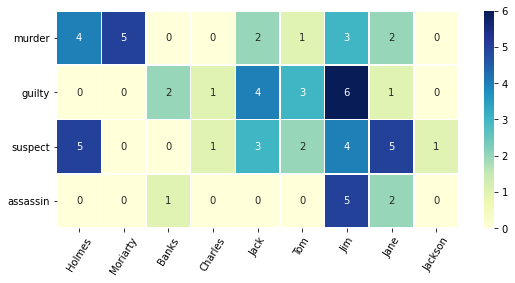

In [14]:
# Example of expected format of data that the method needs
rows_example = ["murder", "guilty","suspect","assassin"]
columns_example = ["Holmes", "Moriarty","Banks","Charles","Jack","Tom","Jim","Jane","Jackson"]
data_example = [[4,5,0,0,2,1,3,2,0],[0,0,2,1,4,3,6,1,0],[5,0,0,1,3,2,4,5,1],[0,0,1,0,0,0,5,2,0]]

# Plot
visualize_co_occurrence(data_example,rows_example,columns_example)
plt.show()

Example of word count histogram

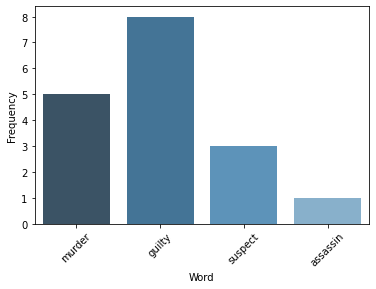

In [17]:
# Example of expected format of data that the method needs
labels_example = ["murder", "guilty", "suspect", "assassin"]
data_example = [5,8,3,1]

# Plot
barplot(data_example,labels_example)
plt.show()

###$\color{brown}{\rm Drivers}$

# Negative words frequency

In [26]:
def get_negative_words(negative_words):
    """
    Get list of negative words
    """
    return [negative_words[match.start():match.end()] for match in re.finditer(r'(?<=\n)[a-zA-Z]+(?=\n)', negative_words)]
    # return [negative_words[match.start():match.end()] for match in re.finditer(r'(?<=\n)[a-zA-Z]+(?=\n)', negative_words)]


def get_top_negative_words(corpus, negative_list, *, top=20):
    """
    Get top list of negative words
    """
    frequency_list = []
    for word in negative_list:
        result_list = [match.span() for match in re.finditer(fr'(?<![a-zA-Z0-9]){word}', corpus)]
        frequency_list.append(len(result_list))
    
    # Sort results
    temp_list = np.asarray(list(zip(negative_list,frequency_list)), dtype = [('word', np.unicode_, 16), ('frequency', int)] )
    sorted_list = np.sort(temp_list, order='frequency', kind="quicksort")
    sorted_list = sorted_list[::-1]

    return sorted_list[:top]


# Get negative words
url = "https://raw.githubusercontent.com/edponce/DoyleInvestigators/develop/negative-words.txt"
negative_words = get_corpus_from_url(url)
result_negative = get_negative_words(negative_words)

# Get corpus (use all text between Gutenberg tags)
corpus = get_corpus('The Valley of Fear')
corpus_l = corpus.lower()
text = get_text_from_span(corpus_l, get_text(corpus_l)[0])

# Get count
results = get_top_negative_words(text, result_negative, top=20)
print(results)

[('fear', 42) ('murder', 39) ('crime', 36) ('dead', 31) ('danger', 30)
 ('doubt', 27) ('dark', 24) ('strange', 22) ('hard', 22) ('bad', 19)
 ('trouble', 17) ('terrible', 15) ('cold', 15) ('struck', 14)
 ('stranger', 14) ('death', 14) ('criminal', 14) ('worse', 13)
 ('dumb', 13) ('warning', 12)]


# Crime-related words frequency

In [ ]:
corpus = get_corpus('The Valley of Fear')
text = corpus.lower()

# Get region of interest (ROI)
roi_span = get_text(text)  # all text
print(roi_span)

# Search keywords
keywords = ['dead', 'death', 'murder', 'crime', 'hurt', 'blood', 'treasure',
            'suffer', 'guilty', 'assassin', 'suspect', 'pain']
keyword_spans = get_keywords_map(text, roi_span[0], keywords)

In [ ]:
# Generate frequency table
keyword_freq = generate_frequency_map(keyword_spans, threshold=5)
print(keyword_freq)

# Plot
labels = list(keyword_freq.keys())
data = list(keyword_freq.values())
print(labels)
print(data)
barplot(data, labels)
plt.show()

# Story structure

In [40]:
def count_text_structure(text, span=None, structure=None):
    if structure is None:
        structure = collections.defaultdict(int)

    for par_span in get_paragraphs(text, span):
        structure['Paragraphs'] += 1
        for sent_span in get_sentences(text, par_span):
            structure['Sentences'] += 1
            for tok_span in get_tokens(text, sent_span):
                structure['Words'] += 1


structures = {}

story = 'The Valley of Fear'
corpus = get_corpus(story)
text = corpus.lower()
structure = collections.defaultdict(int)
for part_span in get_parts(text):
    structure['Parts'] += 1
    for chp_span in get_chapters(text, part_span):
        structure['Chapters'] += 1
        count_text_structure(text, chp_span, structure)
structure['Epilogue'] = 1
span = get_text(text)[0]
structure['Characters'] = span[1] - span[0]
count_text_structure(text, get_epilogue(text)[0], structure)
structures[story] = structure

story = 'A Study in Scarlet'
corpus = get_corpus(story)
text = corpus.lower()
structure = collections.defaultdict(int)
for part_span in get_parts(text):
    structure['Parts'] += 1
    for chp_span in get_chapters(text, part_span):
        structure['Chapters'] += 1
        count_text_structure(text, chp_span, structure)
span = get_text(text)[0]
structure['Characters'] = span[1] - span[0]
structures[story] = structure

story = 'The Sign of the Four'
corpus = get_corpus(story)
text = corpus.lower()
structure = collections.defaultdict(int)
for chp_span in get_chapters(text):
    structure['Chapters'] += 1
    count_text_structure(text, chp_span, structure)
span = get_text(text)[0]
structure['Characters'] = span[1] - span[0]
structures[story] = structure

story = 'The Hound of the Baskervilles'
corpus = get_corpus(story)
text = corpus.lower()
structure = collections.defaultdict(int)
for chp_span in get_chapters(text):
    structure['Chapters'] += 1
    count_text_structure(text, chp_span, structure)
span = get_text(text)[0]
structure['Characters'] = span[1] - span[0]
structures[story] = structure

story = 'The Boscombe Valley Mystery'
corpus = get_corpus(story)
text = corpus.lower()
structure = collections.defaultdict(int)
span = get_adventures(text, n=4)[0]
count_text_structure(text, span, structure)
structure['Characters'] = span[1] - span[0]
structures[story] = structure

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(structures)

{   'A Study in Scarlet': defaultdict(<class 'int'>,
                                      {   'Chapters': 14,
                                          'Characters': 245152,
                                          'Paragraphs': 225,
                                          'Parts': 2,
                                          'Sentences': 5572,
                                          'Words': 43296}),
    'The Boscombe Valley Mystery': defaultdict(<class 'int'>,
                                               {   'Characters': 52449,
                                                   'Paragraphs': 25,
                                                   'Sentences': 1321,
                                                   'Words': 9622}),
    'The Hound of the Baskervilles': defaultdict(<class 'int'>,
                                                 {   'Chapters': 15,
                                                     'Characters': 326567,
                                        

# Count character entities

The Valley of Fear - main


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


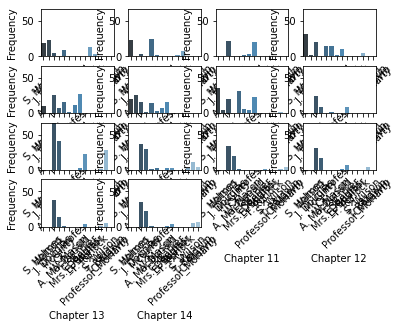

The Valley of Fear - detectives


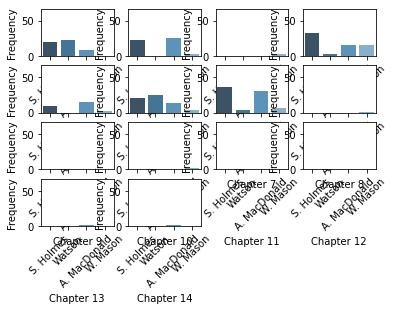

The Valley of Fear - perpetrators


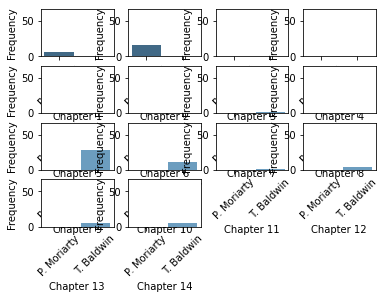

The Valley of Fear - suspects


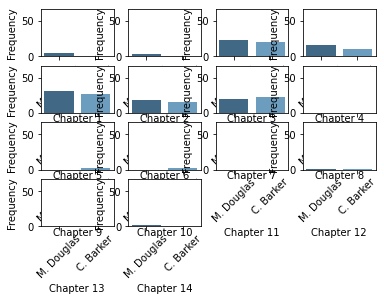

In [25]:
story = 'The Valley of Fear'
# story = 'A Study in Scarlet'

# Select part(s)
# spans = get_parts(get_corpus(story).lower(), n=1)  # n = Part
# span = spans[0]  # [i] = Part i+1
span = None  # all Parts or if no Parts

# Per chapter
story_spans, story_counts = ner_story_with_chapters(story, span)
plot_ner_counts_story_with_chapters(story, story_counts)

# Full story
# story_spans, story_counts = ner_story(story, span)
# plot_ner_counts_story(story, story_counts)

# pp = pprint.PrettyPrinter(indent=2)
# pp.pprint(story_spans)
# pp.pprint(story_counts)

In [ ]:
story = 'The Sign of the Four'
# story = 'The Hound of the Baskervilles'

# Per chapter
story_spans, story_counts = ner_story_with_chapters(story)
plot_ner_counts_story_with_chapters(story, story_counts)

# Full story
# story_spans, story_counts = ner_story(story)
# plot_ner_counts_story(story, story_counts)

# pp = pprint.PrettyPrinter(indent=2)
# pp.pprint(story_spans)
# pp.pprint(story_counts)

In [ ]:
story = 'The Boscombe Valley Mystery'
span = get_adventures(get_corpus(story).lower(), n=4)[0]

# Per paragraph
# story_spans, story_counts = ner_story_with_paragraphs(story, span)
# plot_ner_counts_story_with_paragraphs(story, story_counts)

# Full story
story_spans, story_counts = ner_story(story, span)
plot_ner_counts_story(story, story_counts)

# pp = pprint.PrettyPrinter(indent=2)
# pp.pprint(story_spans)
# pp.pprint(story_counts)